# Analyzing spectrograms of different instruments to discriminate between them

### Author: Vincenzo Gargano

# Signal processing approaches

As we saw at lesson, we have some techniques like Fourier Transforms that given a time series give us the decomposition in frequency domain, or Wavelets that let us analyze signals in both time and frequency domain. That's what we are intrested when we want to analyze music signals, because of the time in which the different harmonics with different frequencies occours matter.

In [ ]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import seaborn as sns
from scipy import signal

# For audio playback, we'll use IPython.display's Audio widget
from IPython.display import Audio



# Loading Data

In [ ]:

# Samples are from: Guitar, Saxophone, Violin, Percussion (different ones) in mp3 format
path_to_samples = '.\all-samples'

# Strings
guitar_harmonic = librosa.load('all-samples/guitar_A3_very-long_piano_harmonics.mp3', sr=44100)[0]
guitar = librosa.load('all-samples/guitar_A3_very-long_piano_normal.mp3', sr=44100)[0]
violin = librosa.load('all-samples/violin_A3_15_forte_arco-normal.mp3', sr= 44100)[0]

#violin_glissato = librosa.load('all-samples/violin_As4_phrase_mezzo-forte_arco-glissando.mp3', sr = 44100)[0] 

# Woodwinds
saxophone = librosa.load('all-samples/saxophone_A3_15_forte_normal.mp3', sr = 44100)[0]
clarinet = librosa.load('all-samples/clarinet_A3_15_forte_normal.mp3', sr = 44100)[0]

# Brass
trumpet = librosa.load('all-samples/trumpet_A3_15_forte_normal.mp3', sr = 44100)[0]


#f0, the sequence of fundamental frequency estimates
#voicing, the sequence of indicator variables for whether a fundamental was detected or not at each time step
#voicing_probability, the sequence of probabilities that each time step contains a fundamental frequency

f0_guitar, voicing_guitar, voiced_prob_guitar = librosa.pyin(guitar, fmin = 50, fmax = 900)
f0_saxophone , voicing_saxophone, voiced_prob_saxohpone = librosa.pyin(saxophone, fmin = 10, fmax = 900)
f0_violin, voicing_violin, voiced_prob_violin = librosa.pyin(violin, fmin = 10, fmax = 900)
f0_trumpet, voicing_trumpet, voiced_prob_trumpet = librosa.pyin(trumpet, fmin = 10, fmax = 900)
f0_clarinet, voicing_clarinet, voiced_prob_clarinet = librosa.pyin(clarinet, fmin = 10, fmax = 900)


# Some experiments...
#f0_violin_glissato, voicing_violin_glissato, voiced_prob_violin_glissato = librosa.pyin(violin_glissato, fmin = 10, fmax = 900)




# Hearing the instruments

Let's hear the sound of some of them before actually peeking at the **spectrograms**. **I suggest to lower the audio**


In [ ]:

Audio(guitar, rate=44100)

In [ ]:
Audio(saxophone, rate=44100)

In [ ]:
Audio(violin, rate=44100)

In [ ]:
Audio(clarinet, rate=44100)

In [ ]:
Audio(trumpet, rate=44100)

In [ ]:
def mean_f0(f0, instrument):

    f0 = f0[0:44100]
    # get rid of nan values
    f0_instrument = f0[~np.isnan(f0)]

    print("Fundamental frequency of", instrument, "is", np.mean(f0_instrument))
    
    return np.mean(f0_instrument)


# Differences between choosen instruments

Now let's discuss chosen instruments, i picked some Strings, Woodwinds and Brass so 3 main classes, because there could be some similarity between these, another intresting instrument is the drum, but i've not added it for some other reasons, this has a pitch, but samples are so short that the spectrogram have a very small time window and so a 'low' resolution.

## Brief instruments description

So what usually gave to the instruments their typical sound is the material and how they produce the sound, for example guitars and violin make sound in different ways usually, but they are build with shared components, both have a fretboard to "fret" the note and a bridge to get the strings in tension. These instruments to produce a certain pitch make the strings vibrate trought the air at certain frequencies.

Instead Brass instruments like the Trumpet are made, as the name suggest, with the former alloy. These along with Woodwinds made of combined plastic and wood pieces produces their pitch by making the air inside the instrument vibrate at certain frequencies.

So the idea before seeing the results is that we expect similar spectrograms between similar instruments.

# STFT 

For the time-frequency analysis the library we are using adoperate the STFT (Short-Time Fourier Transform)

Basically this is a **naive idea**, that everyone can think if only knows the Fourier Transform. 

 The **STFT** algorithm is quite simple, take a signal and applies in a certain window of time, the Fourier Transform, obtaining the power spectrum of a local part of the entire signal, so we get a localized frequency domain of that. What is done after that is that the power spectrum is sent into a more richer space in which we have the time (x-axis) as the windows we took of the main signal, and the power will be the colour, and the frequency will be shown in the y-axis.

# Wavelet

Recalling what we saw at lesson, this is rather different than the **wavelet transform**, essentially if we have our signal we can take a wavelet, that is a function localized in time, a *short-lived* oscillation. 

Wavelets have two main properties

- Zero Mean: aka Admissibility Condition. States that our wavelet cannot have zero frequency components
$$
\int_{-∞}^{+∞} \Psi(t)dt = 0
$$
- Finite energy: this because has to be localized in time.
$$
\int_{-∞}^{+∞} |\Psi(t)|^2dt \lt ∞
$$

What we do with these wavelets is to convolve them with our signal by appling the dot product between the two functions, and compute a measure of similarity, when the convolution returns zero, basically there is no similarity and when the two are in phase we will get a positive contribution and negative when out of phase. Then we proceed to change the scale of the wavelet and repeat to get other frequency components.

## Main differences between Wavelets and STFT

With Wavelet we build the time-frequency domain one frequency at a time for all time points and with the STFT we build the same but 1 time chunk at a time over all the frequencies at once but only in that time window.



In [ ]:
def plot_spectrograms(audio_list, f0_list, instrument_list, sr=44100, ax = None):
    ''' 
    Using audios and given fundamentals we plot the spectrograms
    of each instruments and return the signals of each of them
    '''
    
    index = 0
    S = np.empty(len(audio_list), dtype=object)
    times = np.empty(len(audio_list), dtype=object)
    img = np.empty(len(audio_list), dtype=object)


    for audio in audio_list:
        
        S[index] = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
        times[index] = librosa.times_like(S, sr=sr)
        index += 1        

    sns.set_style('white')

    # Plot the spectrogram in a subplot of each instrument
    
    fig, ax = plt.subplots(nrows=1, ncols=len(audio_list), figsize=(20, 4))
    
    for i in range(0, len(audio_list)):

        img[i] = librosa.display.specshow(librosa.amplitude_to_db(S[i], ref=np.max),
                                 y_axis = 'log', x_axis = 'time', ax = ax[i])
        

        f0_frequency = mean_f0(f0_list[i], instrument_list[i])
     
        ax[i].axhline(f0_frequency, color='blue', linestyle='dotted', linewidth=1.5, label='f0 frequency:' + str(round(f0_frequency,2)) + 'Hz')
        ax[i].set_title('Spectrogram of ' + instrument_list[i])
        ax[i].legend(loc='upper right', fontsize='small')

        # add spacing between subplots
        fig.subplots_adjust(wspace=0.5)

    # one colorbar for all the subplots
    fig.colorbar(img[0], ax=ax.ravel().tolist())
        
    return S
  
   

Fundamental frequency of guitar is 112.00745223306399
Fundamental frequency of saxophone is 106.93509298861399
Fundamental frequency of violin is 109.9778468925591
Fundamental frequency of clarinet is 109.87933824010213
Fundamental frequency of trumpet is 119.05623519735859


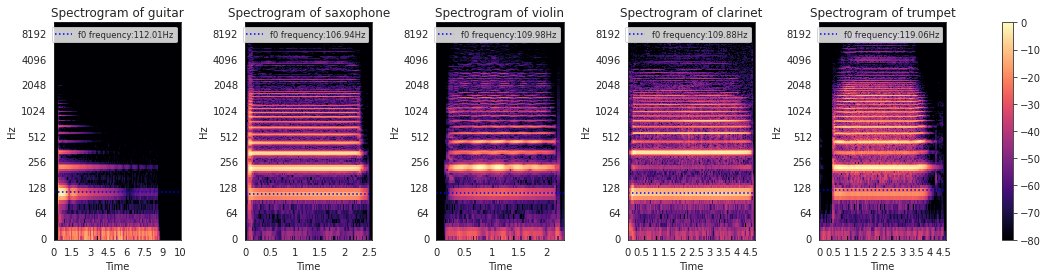

In [ ]:
signals = plot_spectrograms([guitar, saxophone, violin, clarinet, trumpet],
                     [f0_guitar, f0_saxophone, f0_violin, f0_clarinet, f0_trumpet],
                     ['guitar', 'saxophone', 'violin', 'clarinet', 'trumpet'])

# Analysis of spectrograms

Our claim was that similar instruments will have similar spectrograms, but at first glance guitar and violin are quite different from each other.

Let's spend some word describing the plots in general.

## Overtones

Well what we're seeing in all the plot is that each pitch has the fundamental, that's the lowest pitch that is the note we played, and all the "rows" above that are multiples at 1f0 [Fundamental],2f0[Second Harmonic],3f0[Third Harmonic] and so on for all the other harmonics.

We can also see that the most colored part of the spectrogram is only in the overtones, so when an instrument plays a note we're actually hearing all the overtones playing togheter. How these overtones are placed makes the timbre of the instrument.

## Spectrograms Differences

Now by looking at the spectrograms we can infer some information about the instruments, for example the "waving" and little oscillations of the violin spectre is given by the fact that a bow is being used and maybe who played the note put a little vibrato on it. On the other hand, guitar usually is plucked by hand or with a pick, instead of the violin that is played with the bow or usually using the finger with a tecnique called "pizzicato" that gives shorter pitch and can even change the timbre.

So seeing the guitar we can surely point out that the harmonics of this instrument tends to fade away very quickly also seeing the frequency after about 512hz, the 5f0 becomes really 'small'

Similar instruments like clarinet and saxophone instead have a much similar spectrum hence a tone much similar, and seem more linear because there is no vibrato in this case, but the distribution of the volume in the overtone is the key of what we're trying to analize, the clarinet has the third overtone with an higher color on the scale at right, while the saxophone seems that has the second one. And the trumpet has a characteristic 'buzz' in the sound of the instrument that make it more 'noisy' and the volume on the overtones is distributed in a different way.

---



# Conclusions & further development

Timbres is what gives personality to an instrument, expert musicians can identify different timbres in a difficult scenarios, with this simple experiment we've shown that we can look at the spectrogram of the sound of some instrument and understand what make them sound really unique, that is the **pattern of frequencies** that they produce for the same note. For the question: 
- Are the instruments recognizable by spectrogram?

Well to answer this we can say that there are some specific instruments that have a characteristic spectrum, but some other are very similar and is difficult to distinguish them by only looking at the spectrograms, it's easy to confuse a clarinet and a trumpet for example, but guitar has a spectrum much different from the others, more recognizable and unique.

If we want to create for example a tool that can discriminate between instruments we could try for example as we've seen at lesson, to use a classifier on those images, an example could be a Convolutional Neural Network, these are really good at extracting feature that humans find hard to describe.

## Enhancing visualizations spectograms with 3D Plot

I've seen certain tools that are capable to plot in real time 3D spectrograms, unfortunately i couldn't use them, some are proprietary, and i've used python. 
Matlab should be capable of plotting 3D spectrogram.

Seeing the 3D real time spectrograms is much more informative. Especially if the signal are played one after another. For example there are certain instruments that after a pitch being played and their relative frequencies pattern can be easily identified because of some the overtones tends to fade very quickly.


## Cool things i learnt and discovered

1. During the research for the assignment i found another useful tool related to timbre analysis and syntesis, for example google deplayed https://sites.research.google/tonetransfer, a tool that allows to transfer the timbre of one instrument to another.

2. Well i find very intresting the fact that STFT and Wavelet are doing basically the same thing but in two different way, the two approaches have their limits, for example when we're working on a certain signal there is everytime a tradeoff between frequency and time resolution. 

3. The overtone series is well known in math as the Harmonic series. Usually on guitar we can play natural harmonics by only placing our finger over the string at certain lenght of it, and doing this we're cutting some of the overtones and making sound only a certain subgroup of them, making a "different" sound.

### Resources

- For the Wavelet explaination i've found a great content: [Wavelet microscope](https://www.youtube.com/watch?v=jnxqHcObNK4)

- [Natural Harmonics on guitar strings](https://music.stackexchange.com/questions/30457/why-do-harmonics-played-on-guitar-sound-lower-as-you-move-to-higher-frets-while)